# Dataclass Creator

In this notebook we declare a dataclass used to treat individual images as objects for use in a future WorldFloods 2.0 database.

* [X] Get the preexisting WorldFloods data from bucket.
* [ ] Extract relevant metadata for each image.
* [ ] Generate dataclass object given metadata.
* [ ] Define generic methods to save and load images (i.e COG)
* [ ] Save a sample dataclass and load.
* [ ] Define a structure for meta-meta-data (hierarchy).
* [ ] Write an `ingest.py` script
* [ ] GO HAMMMM
* [ ] Profit

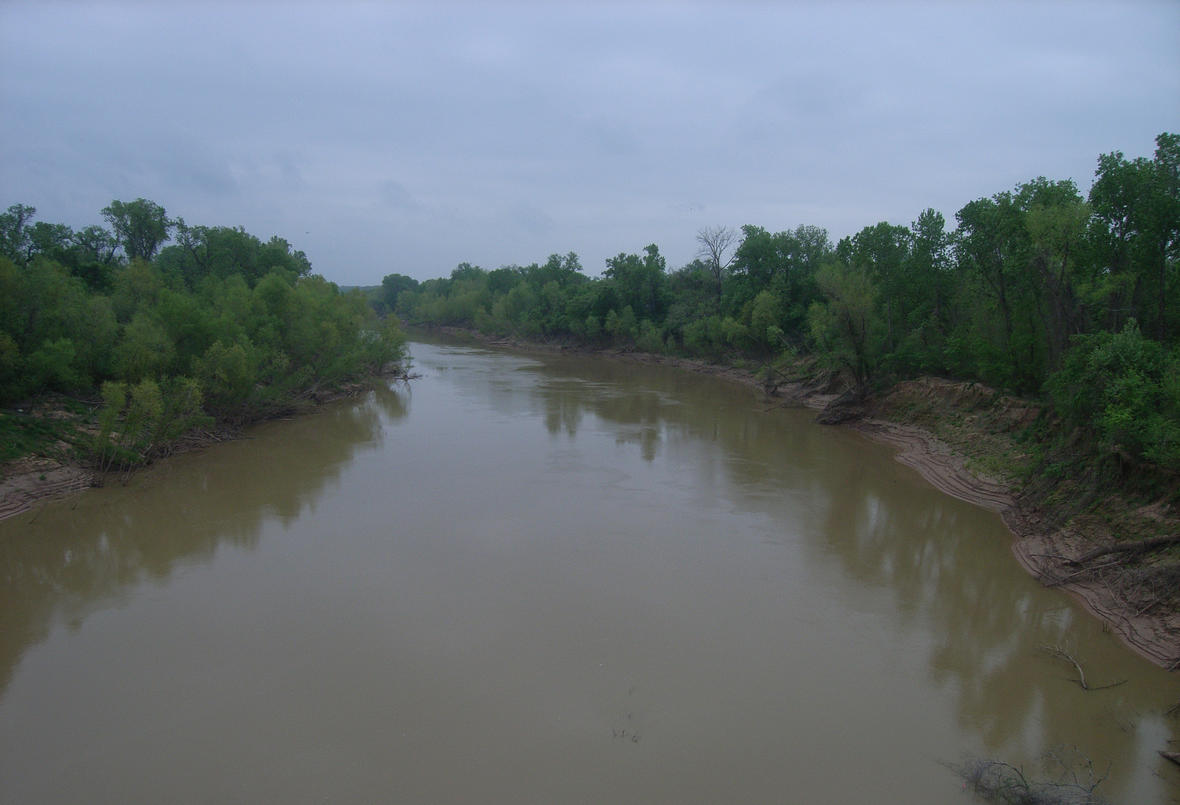
The Brazos River Near Hempstead Texas.

## Retrieve Pre-existing WorldFloods Data From the Bucket

The demonstration file used for this demonstration are from the following bucket corresponding to Sentinel-2 data:
- Sentinel-2 TIFF images:
    - [gs://ml4floods/worldfloods/public/train/S2](gs://ml4floods/worldfloods/public/train/S2)
- Sentinel-2 metadata:
    - [gs://ml4floods/worldfloods/public/train/meta](gs://ml4floods/worldfloods/public/train/meta)


The actual file is a satellite image over the Brazos River in Hempstead, Texas and can be found in the current WorldFloods Google Cloud bucket which can be accessed directly using this [link](https://storage.cloud.google.com/ml4floods/worldfloods/public/train/S2/05282016_Brazos_River_near_Hempstead_TX.tif) or this [URI](gs://ml4floods/worldfloods/public/train/S2/05282016_Brazos_River_near_Hempstead_TX.tif).

Before we begin, let's check if the file we are interested in exists.


### Check If the File Exists
- Use the `google cloud` package to access the file storage bucket and interact with the Google Cloud Storage API.
- Use the `pathlib` module to traverse the file path system.

To determine whether a file exists we take advantage of a `google.cloud.storage.blob.Blob` object which corresponds to the path of an object in a the Google Cloud Storage bucket we are interested in. For more information about the gcp Blob objects refer to the following [documentation](https://googleapis.dev/python/storage/latest/blobs.html).

In [6]:
from typing import List, Dict
from google.cloud import storage
from pathlib import Path

In [7]:
def check_file_in_bucket_exists(bucket_name: str, filename_full_path: str, **kwargs) -> bool:
    """
    Function to check if the file in the bucket exist utilizing Google Cloud Storage
    (GCP) blobs.

    Args:
      bucket_name (str): a string corresponding to the name of the GCP bucket.
      filename_full_path (str): a string containing the full path from bucket to file.

    Returns:
      A boolean value corresponding to the existence of the file in the bucket.
    """
    # initialize client
    client = storage.Client(**kwargs)
    # get bucket
    bucket = client.get_bucket(bucket_name)
    # get blob
    blob = bucket.blob(filename_full_path)
    # check if it exists
    return blob.exists()

Let's test if the file [gs://ml4floods/worldfloods/public/train/S2/05282016_Brazos_River_near_Hempstead_TX.tif] exists using our predefined function `check_file_in_bucket_exists`. Notice that the first directory immediately after the Google Storage index `gs://` is the name of the bucket, or `bucket_id`, while the rest of the path up until the file name with file extension is the full file name.

In [8]:
gs_index = "gs://"
bucket_id = "ml4floods"
path = "worldfloods/public/"
sub_dir = "train/S2"
file_name = "05282016_Brazos_River_near_Hempstead_TX.tif"


uri_full = gs_index + str(Path(bucket_id).joinpath(path).joinpath(sub_dir).joinpath(file_name))
file_path = str(Path(path).joinpath(sub_dir).joinpath(file_name))

print("URI verification: ", uri_full)

# Testing to see if the file exists in the GCP bucket
print("Does the file exist: ", check_file_in_bucket_exists(bucket_id, file_path))

URI verification:  gs://ml4floods/worldfloods/public/train/S2/05282016_Brazos_River_near_Hempstead_TX.tif
Does the file exist:  True


## Extract Relevant Metadata for the Image
To fetch the metadata we manipulate the path to retrieve the `.json` file affiliated with the filename.

In [9]:
# Define a function that will take the URI of the S2 image and use regex to manipulate it to meta

In [10]:
import json
from google.cloud import storage

def load_json_from_bucket(bucket_name: str, filename: str, **kwargs) -> Dict:
    """
    Function to load the json data for the WorldFloods bucket using the filename
    corresponding to the image file name. The filename corresponds to the full
    path following the bucket name through intermediate directories to the final
    json file name.

    Args:
      bucket_name (str): the name of the Google Cloud Storage (GCP) bucket.
      filename (str): the full path following the bucket_name to the json file.

    Returns:
      The unpacked json data formatted to a dictionary.
    """
    # initialize client
    client = storage.Client(**kwargs)
    # get bucket
    bucket = client.get_bucket(bucket_name)
    # get blob
    blob = bucket.blob(filename)
    # check if it exists
    # TODO: wrap this within a context
    return json.loads(blob.download_as_string(client=None))

In [11]:
# Testing the json_loader
d = load_json_from_bucket('ml4floods', 'worldfloods/public/train/meta/05282016_Brazos_River_near_Hempstead_TX.json')


In [12]:
print(d)

{'source': 'glofimr', 'satellite': 'Landsat-8', 'satellite date': '2016-05-28T00:00:00Z', 'shape': [989, 1634], 'pixels invalid S2': 0, 'pixels clouds S2': 906726, 'pixels water S2': 274958, 'pixels land S2': 434342, 'pixels flood water S2': 265661, 'pixels hydro water S2': 0, 'pixels permanent water S2': 9297, 'method clouds': 's2cloudless', 'bounds': [-96.22789256099679, 30.136231993999647, -96.08110784357166, 30.22507537559907], 's2metadata': [{'date_string': '2016-06-01 17:11', 'system:time_start': 1464801085000, 'area_rel': 100}]}


In [13]:
for k, v in d.items():
    print(k, type(v))

source <class 'str'>
satellite <class 'str'>
satellite date <class 'str'>
shape <class 'list'>
pixels invalid S2 <class 'int'>
pixels clouds S2 <class 'int'>
pixels water S2 <class 'int'>
pixels land S2 <class 'int'>
pixels flood water S2 <class 'int'>
pixels hydro water S2 <class 'int'>
pixels permanent water S2 <class 'int'>
method clouds <class 'str'>
bounds <class 'list'>
s2metadata <class 'list'>


## Generate a Dataclass Object To Package the Metadata with the Image


In [16]:
from dataclasses import dataclass

def make_dc(d, name='d_dataclass'):
    @dataclass
    class Wrapped:
        __annotations__ = {k: type(v) for k, v in d.items()}
        
    Wrapped.__qualname__ = Wrapped.__name__ = name

    return Wrapped

In [17]:
make_dc(d)

SyntaxError: invalid syntax (<string>, line 1)

In [25]:

from dataclasses import dataclass
d_dataclass = dataclass(type('d_dataclass', (), {'__annotations__': {str(k): type(v) for k, v in d.items()}}))


SyntaxError: invalid syntax (<string>, line 1)

In [ ]:
from dataclasses import dataclass, field
from datetime import datetime
from typing import List, Dict


@dataclass
class WorldFloodsImage:
    # ESSENTIAL METADATA
    filename: str
    uri: str = field(default=None)
    filepath: str = field(default=None)
    bucket_id: str= field(default=None)
    product_id: str = field(default=None)
    
    # BREADCRUMBS
    load_date: str = field(default = datetime.now())
    viewed_by: list = field(default_factory = list, compare = False, repr = False)
    source_system: str = field(default = "Not Specified")

In [43]:
from google.cloud import storage

#name = 'worldfloods/public/train/S2/05282016_Brazos_River_near_Hempstead_TX.tif'   
storage_client = storage.Client()
# bucket_name = 'ml4floods'
bucket = storage_client.bucket(bucket_id)
stats = storage.Blob(bucket=bucket, name=full_path).exists(storage_client)

Forbidden: 403 GET https://storage.googleapis.com/storage/v1/b/ml4floods/o/gs%3A%2F%2Fml4floods%2Fworldfloods%2Fpublic%2Ftrain%2FS2%2F05282016_Brazos_River_near_Hempstead_TX.tif?fields=name&prettyPrint=false: 299481927484-compute@developer.gserviceaccount.com does not have storage.objects.get access to the Google Cloud Storage object.

In [30]:
bucket_id = 'ml4floods'
path_to_file = 'ml4floods/worldfloods/public/train/S2/'
file_name = '05282016_Brazos_River_near_Hempstead_TX.tif'
print(path_to_file + file_name)

ml4floods/worldfloods/public/train/S2/05282016_Brazos_River_near_Hempstead_TX.tif


In [32]:
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_id)
stats = storage.Blob(bucket=bucket, name=path_to_file + file_name).exists(storage_client)

Forbidden: 403 GET https://storage.googleapis.com/storage/v1/b/ml4floods/o/ml4floods%2Fworldfloods%2Fpublic%2Ftrain%2FS2%2F05282016_Brazos_River_near_Hempstead_TX.tif?fields=name&prettyPrint=false: 299481927484-compute@developer.gserviceaccount.com does not have storage.objects.get access to the Google Cloud Storage object.

In [16]:
client = storage.Client()
bucket = client.get_bucket("ml4floods")
assert isinstance(bucket.get_blob(path_to_file + file_name), Blob)


Forbidden: 403 GET https://storage.googleapis.com/storage/v1/b/ml4floods?projection=noAcl&prettyPrint=false: 299481927484-compute@developer.gserviceaccount.com does not have storage.buckets.get access to the Google Cloud Storage bucket.

In [12]:
def check_file_in_bucket_exists(bucket_name: str, filename: str, **kwargs) -> bool:
    # initialize client
    client = storage.Client(**kwargs)
    # get bucket
    bucket = client.get_bucket(bucket_name)
    # get blob
    blob = bucket.blob(filename)
    # check if it exists
    return blob.exists()


In [ ]:
print(check_file_in_bucket_exists(bucket_id))

The WorldFloods bucket 

In [11]:
print(stats)

<Blob: ml4floods, thisdoesnotexist.tif, None>


In [6]:
print(stats.name)

worldfloods/public/train/S2/05042017_Castor_River_at_Zalma_MO0000000000-0000000000.tif


In [11]:
!gsutil cp ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif .

CommandException: No URLs matched: ml4floods/worldfloods/public/train/S2/01042016_Holmes_Creek_at_Vernon_FL.tif


In [7]:
storage_client = storage.Client()
blobs = storage_client.list_blobs('ml4floods', prefix=name)
file_list = [i.exists() for i in blobs]
    

Forbidden: 403 GET https://storage.googleapis.com/storage/v1/b/ml4floods/o?projection=noAcl&prefix=worldfloods%2Fpublic%2Ftrain%2FS2%2F05042017_Castor_River_at_Zalma_MO0000000000-0000000000.tif&prettyPrint=false: 299481927484-compute@developer.gserviceaccount.com does not have storage.objects.list access to the Google Cloud Storage bucket.